# Report Plots

## Importing Packages and Downloading Tools

In [1]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import seaborn as sns
import random
import time

In [2]:
from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)

download('https://github.com/AllenDowney/ThinkComplexity2/raw/master/notebooks/utils.py')

def read_graph(filename):
    """Reads a graph from a .txt file"""
    G = nx.Graph()
    array = np.loadtxt(filename, dtype=int)
    G.add_edges_from(array)
    return G

## Downloading Road Network Data

In [152]:
rd = read_graph('road-minnesota/road-minnesota.mtx')
print(len(rd.nodes()))
print(len(rd.edges()))

2642
3303


## Downloading Electrical Grid Graph

This graph is a model of the Western United States electrical grid. You can find more information [here](http://konect.cc/networks/opsahl-powergrid/).

In [4]:
eg = read_graph('opsahl-powergrid/out.opsahl-powergrid')
print(len(eg.nodes()))
print(len(eg.edges()))

4941
6594


## Helper Functions


In [6]:



def sample_path_lengths(G, nodes=None, trials=1000):
    """Choose random pairs of nodes and compute the path length between them.

    G: Graph
    nodes: list of nodes to choose from
    trials: number of pairs to choose

    returns: list of path lengths
    """
    if nodes is None:
        nodes = list(G)
    else:
        nodes = list(nodes)
    
    pairs = np.random.choice(nodes, (trials, 2))
    lengths = []
    for pair in pairs:
        try:
            path = nx.shortest_path_length(G, *pair)
            lengths.append(path)
        except:
            pass
    return lengths


def average_shortest_path(G):
    """Returns the average shortest path length between two random nodes over n trials
    """
    return np.mean(sample_path_lengths(G))


def clusters(G):
    """Finds the largest connected cluster in the graph, G, and the average size of all isolated clusters
    returns a tuple of (relative largest cluster size, average isolated cluster size)
    """
    largest = len(max(nx.connected_components(G), key=len))
    sizes = [len(i) for i in nx.connected_components(G)]
    sizes.remove(largest)
    average_isolated = np.mean(sizes) if sizes else 0
    return largest/len(G.nodes()), average_isolated


def run_attack(G, attack, step=.01, max_removal=0.8):
    """ Runs as attack (either targeted or random) on a graph then returns properties that are useful
    for analysis.
    
    G: Graph to attack
    attack: type of attack function to test
    step: what fraction (of nodes/edges) to remove on every step
    max_removal: the maximum fraction to stop at
    
    Returns a tuple of lists:
    (fraction steps, relative largest size, average isolated size, average shortest path)
    """
    G = G.copy()
    k = int(max_removal/step)
    f_step = np.linspace(0,k,k+1)*step
    rel_largest, avg_isolated, avg_path = [], [], []
    n = len(G)
    m = len(G.edges())

    t0 = time.time()
    for i in f_step:
        # calculate cluster properties
        rel_lg, avg_iso = clusters(G)

        # add properties
        rel_largest.append(rel_lg)
        avg_isolated.append(avg_iso)
#         if (rel_lg >= 1.0):
        avg_path.append(average_shortest_path(G))
        
        # remove nodes
        attack(G, int(step*n), int(step*m))
            
    print("time: ", time.time() - t0)
    return (f_step, rel_largest, avg_isolated, avg_path)

## Pickling

In [10]:
# Store data
import pickle
import os


def store(file, data):
    files = os.listdir("data/")
    count = len([i for i in files if i[:len(file)] == file])
    filename = 'data/' + file + '_' + str(count) + '.pickle'
    with open(filename, 'wb') as handle:
        pickle.dump(data, handle)

def load(file):
    filename = 'data/' + file + '.pickle'
    with open(filename, 'rb') as handle:
        data = pickle.load(handle)
    return data

def load_avg(file):
    files = os.listdir("data/")
    count = len([i for i in files if i[:len(file)] == file])
    data = [load(file + '_' + str(i)) for i in range(count)]
    
    f_step = data[0][0]
    rel_largest = []
    avg_isolated = []
    avg_path = []
    
    for i in range(len(f_step)):
        rl = 0
        ai = 0
        ap = 0
        for j in range(count):
            rl += data[j][1][i]
            ai += data[j][2][i]
            ap += data[j][3][i]
        rel_largest.append(rl/count)
        avg_isolated.append(ai/count)
        avg_path.append(ap/count)
        
    return (f_step, rel_largest, avg_isolated, avg_path)
    
    

## Random Node Removal

In [7]:
def random_node_attack(G, k, m):
    """Returns a graph with k nodes removed at random"""
    nodes_removed = random.sample(list(G.nodes),k=k)
    G.remove_nodes_from(nodes_removed)

## Targeted Node Removal

In [8]:
def target_node_attack(G, k, m):
    """
    Targets k nodes with the most connections, then removes those node.
    G: Graph to target
    """
    for i in range(k):
        degrees = dict(G.degree())
        target = max(degrees, key=degrees.get)
        G.remove_node(target)

## Random Edge Removal

In [9]:
def random_edge_attack(G, k, m):
    """Returns a graph with k nodes removed at random"""
    edges_removed = random.sample(list(G.edges),k=m)
    G.remove_edges_from(edges_removed)

### Paper Data

In [95]:
n = 10000
m = 2*n
k = round(m/n)

ER = nx.gnm_random_graph(n, m)
HK = nx.powerlaw_cluster_graph(n=n, m=k, p=.5)

er_paper_rn = run_attack(ER, random_node_attack, step=.005)
er_paper_tn = run_attack(ER, target_node_attack, step=.005)
er_paper_re = run_attack(ER, random_edge_attack, step=.005)

hk_paper_rn = run_attack(HK, random_node_attack, step=.005)
hk_paper_tn = run_attack(HK, target_node_attack, step=.005)
hk_paper_re = run_attack(HK, random_edge_attack, step=.005)

KeyboardInterrupt: 

In [162]:
n = 10000
m = 2*n
k = round(m/n)

for i in range(9):

    rd_rn = run_attack(rd, random_node_attack, step=.005)
    rd_re = run_attack(rd, random_edge_attack, step=.005)

    store("rd_rn", rd_rn)
    store("rd_re", rd_re)

time:  40.62338614463806
time:  55.45982336997986
time:  47.772414207458496
time:  52.80539917945862
time:  44.8083074092865
time:  62.66142535209656
time:  45.8603093624115
time:  57.9883930683136
time:  50.122281551361084
time:  53.66525220870972
time:  44.22220182418823
time:  62.61828422546387
time:  46.445215463638306
time:  61.31126809120178
time:  45.978211402893066
time:  52.506205558776855
time:  44.666146755218506
time:  54.16718506813049


### Minnesota Road Network

In [153]:
rd_rn = run_attack(rd, random_node_attack, step=.005)
rd_tn = run_attack(rd, target_node_attack, step=.005)
rd_re = run_attack(rd, random_edge_attack, step=.005)

time:  43.69957947731018
time:  23.04031229019165
time:  56.665603160858154


### Electrical Grid Data

In [70]:
eg_rn = run_attack(eg, random_node_attack, step=.005)
eg_tn = run_attack(eg, target_node_attack, step=.005)
eg_re = run_attack(eg, random_edge_attack, step=.005)

time:  77.71715903282166
time:  86.69043684005737


### Adding Current Data to Repo

In [154]:
store("er_paper_rn", er_paper_rn)
store("er_paper_tn", er_paper_tn)
store("er_paper_re", er_paper_re)

store("hk_paper_rn", hk_paper_rn)
store("hk_paper_tn", hk_paper_tn)
store("hk_paper_re", hk_paper_re)


store("rd_rn", rd_rn)
store("rd_tn", rd_tn)
store("rd_re", rd_re)

store("eg_rn", eg_rn)
store("eg_tn", eg_tn)
store("eg_re", eg_re)

### Big Run

In [163]:
n = 10000
m = 2*n
k = round(m/n)

for i in range(20):

    ER = nx.gnm_random_graph(n, m)
    HK = nx.powerlaw_cluster_graph(n=n, m=k, p=.5)

    er_paper_rn = run_attack(ER, random_node_attack, step=.005)
    er_paper_tn = run_attack(ER, target_node_attack, step=.005)
    er_paper_re = run_attack(ER, random_edge_attack, step=.005)

    hk_paper_rn = run_attack(HK, random_node_attack, step=.005)
    hk_paper_tn = run_attack(HK, target_node_attack, step=.005)
    hk_paper_re = run_attack(HK, random_edge_attack, step=.005)
    
    rd_rn = run_attack(rd, random_node_attack, step=.005)
    rd_re = run_attack(rd, random_edge_attack, step=.005)
    
    eg_rn = run_attack(eg, random_node_attack, step=.005)
    eg_re = run_attack(eg, random_edge_attack, step=.005)
    
    store("er_paper_rn", er_paper_rn)
    store("er_paper_tn", er_paper_tn)
    store("er_paper_re", er_paper_re)

    store("hk_paper_rn", hk_paper_rn)
    store("hk_paper_tn", hk_paper_tn)
    store("hk_paper_re", hk_paper_re)


    store("rd_rn", rd_rn)
    store("rd_re", rd_re)

    store("eg_rn", eg_rn)
    store("eg_re", eg_re)

time:  21.87407112121582
time:  46.017157793045044
time:  31.50410509109497
time:  14.189008951187134
time:  39.17013669013977
time:  20.607064723968506
time:  43.4631073474884
time:  48.93812823295593
time:  52.06612825393677
time:  63.973158836364746
time:  23.66405725479126
time:  45.361111640930176
time:  31.374064445495605
time:  14.868024349212646
time:  38.4300696849823
time:  20.89404034614563
time:  40.8870747089386
time:  51.16809272766113
time:  56.11109638214111
time:  54.21409606933594
time:  23.88603448867798
time:  45.98306584358215
time:  31.787043809890747
time:  15.29702091217041
time:  39.96106195449829
time:  21.155029296875
time:  46.09106469154358
time:  51.34807229042053
time:  49.27206015586853
time:  99.72921228408813
time:  23.092023372650146
time:  44.70905089378357
time:  31.811037302017212
time:  15.5240159034729
time:  37.95904302597046
time:  20.742021322250366
time:  42.31303787231445
time:  52.06704354286194
time:  43.42903709411621
time:  78.9970707893

KeyboardInterrupt: 

### Loading Average Data from Repo

In [164]:
er_paper_rn_avg = load_avg("er_paper_rn")
er_paper_tn_avg = load_avg("er_paper_tn")
er_paper_re_avg = load_avg("er_paper_re")

hk_paper_rn_avg = load_avg("hk_paper_rn")
hk_paper_tn_avg = load_avg("hk_paper_tn")
hk_paper_re_avg = load_avg("hk_paper_re")

rd_rn_avg = load_avg("rd_rn")
rd_tn_avg = load_avg("rd_tn")
rd_re_avg = load_avg("rd_re")

eg_rn_avg = load_avg("eg_rn")
eg_tn_avg = load_avg("eg_tn")
eg_re_avg = load_avg("eg_re")

## Figure 1 & 2

Plot Average Shortest Path

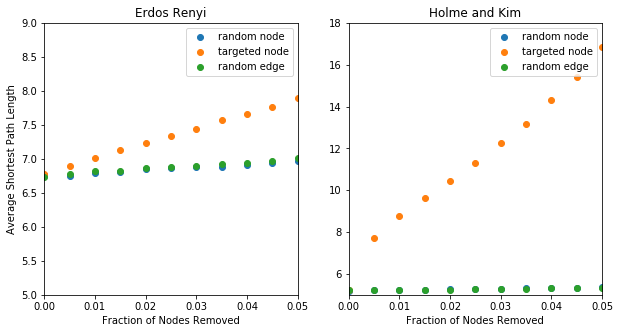

In [165]:
er_rn = er_paper_rn_avg
er_tn = er_paper_tn_avg
er_re = er_paper_re_avg
hk_rn = hk_paper_rn_avg
hk_tn = hk_paper_tn_avg
hk_re = hk_paper_re_avg

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.scatter(er_rn[0], er_rn[3])
plt.scatter(er_tn[0], er_tn[3])
plt.scatter(er_re[0], er_re[3])
plt.title("Erdos Renyi")
plt.ylabel("Average Shortest Path Length")
plt.xlabel("Fraction of Nodes Removed")
plt.legend(["random node", "targeted node", "random edge"])
plt.xlim(0,.05)
plt.ylim(5, 9)

plt.subplot(1,2,2)
plt.scatter(hk_rn[0], hk_rn[3])
plt.scatter(hk_tn[0], hk_tn[3])
plt.scatter(hk_re[0], hk_re[3])
plt.title("Holme and Kim")
plt.xlabel("Fraction of Nodes Removed")
plt.legend(["random node", "targeted node", "random edge"])
plt.xlim(0,.05)
plt.ylim(5, 18)

plt.savefig("C:/Users/wfairman/Desktop/ThinkComplexity2/complex_graph_robustness/reports/figures/fig1.jpg")
plt.show()


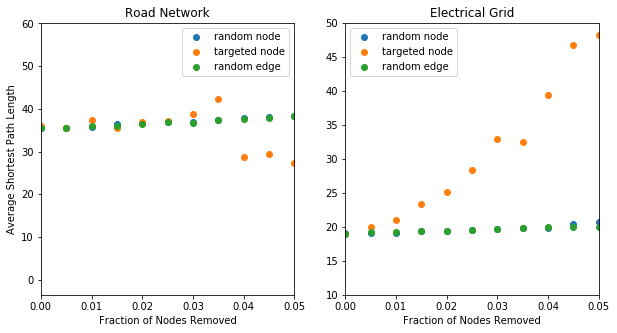

In [173]:
er_rn = rd_rn_avg
er_tn = rd_tn_avg
er_re = rd_re_avg
ws_rn = eg_rn_avg
ws_tn = eg_tn_avg
ws_re = eg_re_avg

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.scatter(er_rn[0], er_rn[3])
plt.scatter(er_tn[0], er_tn[3])
plt.scatter(er_re[0], er_re[3])
plt.title("Road Network")
plt.ylabel("Average Shortest Path Length")
plt.xlabel("Fraction of Nodes Removed")
plt.legend(["random node", "targeted node", "random edge"])
plt.xlim(0,.05)
# plt.ylim(5, 10)

plt.subplot(1,2,2)
plt.scatter(ws_rn[0], ws_rn[3])
plt.scatter(ws_tn[0], ws_tn[3])
plt.scatter(ws_re[0], ws_re[3])
plt.title("Electrical Grid")
plt.xlabel("Fraction of Nodes Removed")
plt.legend(["random node", "targeted node", "random edge"])
plt.xlim(0,.05)
plt.ylim(10,50)

plt.savefig("C:/Users/wfairman/Desktop/ThinkComplexity2/complex_graph_robustness/reports/figures/fig2.jpg")
plt.show()


## Figure 3 & 4

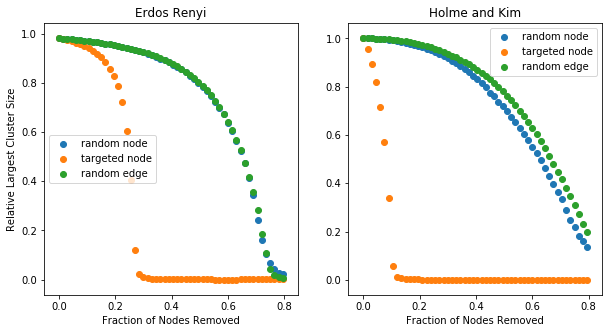

In [167]:
er_rn = er_paper_rn_avg
er_tn = er_paper_tn_avg
er_re = er_paper_re_avg
hk_rn = hk_paper_rn_avg
hk_tn = hk_paper_tn_avg
hk_re = hk_paper_re_avg

k = 3

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.scatter(er_rn[0][::k], er_rn[1][::k])
plt.scatter(er_tn[0][::k], er_tn[1][::k])
plt.scatter(er_re[0][::k], er_re[1][::k])
plt.title("Erdos Renyi")
plt.ylabel("Relative Largest Cluster Size")
plt.xlabel("Fraction of Nodes Removed")
plt.legend(["random node", "targeted node", "random edge"])
# plt.xlim(0,.05)
# plt.ylim(5, 10)

plt.subplot(1,2,2)
plt.scatter(hk_rn[0][::k], hk_rn[1][::k])
plt.scatter(hk_tn[0][::k], hk_tn[1][::k])
plt.scatter(hk_re[0][::k], hk_re[1][::k])
plt.title("Holme and Kim")
plt.xlabel("Fraction of Nodes Removed")
plt.legend(["random node", "targeted node", "random edge"])
# plt.xlim(0,.05)
# plt.ylim(15,40)

plt.savefig("C:/Users/wfairman/Desktop/ThinkComplexity2/complex_graph_robustness/reports/figures/fig3.jpg")
plt.show()

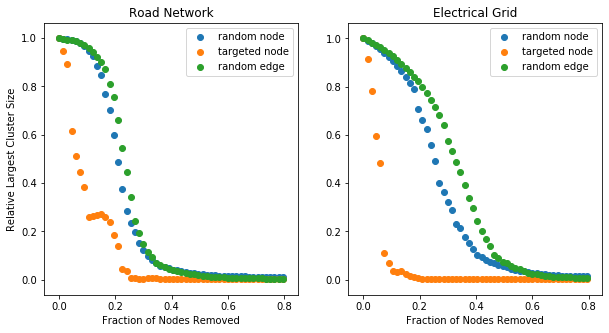

In [168]:
er_rn = rd_rn_avg
er_tn = rd_tn_avg
er_re = rd_re_avg
hk_rn = eg_rn_avg
hk_tn = eg_tn_avg
hk_re = eg_re_avg

k = 3

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.scatter(er_rn[0][::k], er_rn[1][::k])
plt.scatter(er_tn[0][::k], er_tn[1][::k])
plt.scatter(er_re[0][::k], er_re[1][::k])
plt.title("Road Network")
plt.ylabel("Relative Largest Cluster Size")
plt.xlabel("Fraction of Nodes Removed")
plt.legend(["random node", "targeted node", "random edge"])
# plt.xlim(0,.05)
# plt.ylim(5, 10)

plt.subplot(1,2,2)
plt.scatter(hk_rn[0][::k], hk_rn[1][::k])
plt.scatter(hk_tn[0][::k], hk_tn[1][::k])
plt.scatter(hk_re[0][::k], hk_re[1][::k])
plt.title("Electrical Grid")
plt.xlabel("Fraction of Nodes Removed")
plt.legend(["random node", "targeted node", "random edge"])
# plt.xlim(0,.05)
# plt.ylim(15,40)

plt.savefig("C:/Users/wfairman/Desktop/ThinkComplexity2/complex_graph_robustness/reports/figures/fig4.jpg")
plt.show()

## Figure 5 & 6

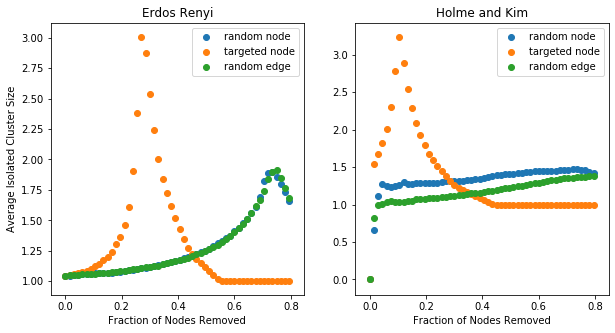

In [169]:
er_rn = er_paper_rn_avg
er_tn = er_paper_tn_avg
er_re = er_paper_re_avg
hk_rn = hk_paper_rn_avg
hk_tn = hk_paper_tn_avg
hk_re = hk_paper_re_avg

k = 3

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.scatter(er_rn[0][::k], er_rn[2][::k])
plt.scatter(er_tn[0][::k], er_tn[2][::k])
plt.scatter(er_re[0][::k], er_re[2][::k])
plt.title("Erdos Renyi")
plt.ylabel("Average Isolated Cluster Size")
plt.xlabel("Fraction of Nodes Removed")
plt.legend(["random node", "targeted node", "random edge"])
# plt.xlim(0,.05)
# plt.ylim(5, 10)

plt.subplot(1,2,2)
plt.scatter(hk_rn[0][::k], hk_rn[2][::k])
plt.scatter(hk_tn[0][::k], hk_tn[2][::k])
plt.scatter(hk_re[0][::k], hk_re[2][::k])
plt.title("Holme and Kim")
plt.xlabel("Fraction of Nodes Removed")
plt.legend(["random node", "targeted node", "random edge"])
# plt.xlim(0,.05)
# plt.ylim(15,40)

plt.savefig("C:/Users/wfairman/Desktop/ThinkComplexity2/complex_graph_robustness/reports/figures/fig5.jpg")
plt.show()

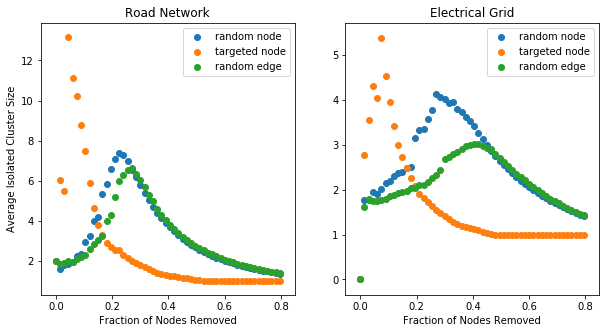

In [170]:
er_rn = rd_rn_avg
er_tn = rd_tn_avg
er_re = rd_re_avg
hk_rn = eg_rn_avg
hk_tn = eg_tn_avg
hk_re = eg_re_avg

k = 3

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.scatter(er_rn[0][::k], er_rn[2][::k])
plt.scatter(er_tn[0][::k], er_tn[2][::k])
plt.scatter(er_re[0][::k], er_re[2][::k])
plt.title("Road Network")
plt.ylabel("Average Isolated Cluster Size")
plt.xlabel("Fraction of Nodes Removed")
plt.legend(["random node", "targeted node", "random edge"])
# plt.xlim(0,.05)
# plt.ylim(5, 10)

plt.subplot(1,2,2)
plt.scatter(hk_rn[0][::k], hk_rn[2][::k])
plt.scatter(hk_tn[0][::k], hk_tn[2][::k])
plt.scatter(hk_re[0][::k], hk_re[2][::k])
plt.title("Electrical Grid")
plt.xlabel("Fraction of Nodes Removed")
plt.legend(["random node", "targeted node", "random edge"])
# plt.xlim(0,.05)
# plt.ylim(15,40)

plt.savefig("C:/Users/wfairman/Desktop/ThinkComplexity2/complex_graph_robustness/reports/figures/fig6.jpg")
plt.show()